In [1]:
import torch as T
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.datasets import CIFAR10
import numpy as np
from sklearn.model_selection import train_test_split

if T.cuda.is_available():
    T.set_default_device("cuda")


In [ ]:
feature_ex = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
feature_ex.eval()

In [ ]:
feature_ex.

In [3]:
from torchvision.transforms import ToTensor
cifar10 = CIFAR10("/tmp", download=False, transform=ToTensor())


In [4]:
X = cifar10.data.astype(np.float32) / 255.0
X = X.transpose(0, 3, 1, 2)
y = cifar10.targets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=420, train_size=5000, test_size=3000)
X_train_T = T.tensor(X_train)
X_test_T = T.tensor(X_test)
y_train_T = T.tensor(y_train)
y_test_T = T.tensor(y_test)

In [8]:
from torch.utils.data import TensorDataset, DataLoader

dl = DataLoader(TensorDataset(X_train_T), batch_size=100, shuffle=False)
features = []
for batch in dl:
    data_pts, = batch
    with T.no_grad():
        feats = feature_ex.features(data_pts)
    features.append(feats)
features = T.cat(features)

In [11]:
features.squeeze_()

tensor([[ 0.3005, -0.6526, -0.5819,  ...,  0.4642, -0.2205,  0.0813],
        [-0.2366, -1.4084, -1.9417,  ...,  1.7560, -0.4283, -1.3822],
        [-0.1716,  0.3685,  1.8765,  ..., -0.0531, -0.4318,  0.7838],
        ...,
        [-0.2592,  0.9366, -1.6321,  ...,  3.1355,  0.1080, -0.1500],
        [ 0.6739,  1.3061, -3.4381,  ...,  3.3047, -0.3246, -0.5983],
        [ 0.9283, -0.7834, -0.5490,  ..., -1.4864, -0.4532,  0.6415]])

In [14]:
from MulticoreTSNE import MulticoreTSNE as TSNE

X_train_proj = TSNE(n_jobs=8, random_state=420, perplexity=30).fit_transform(features.cpu().numpy())



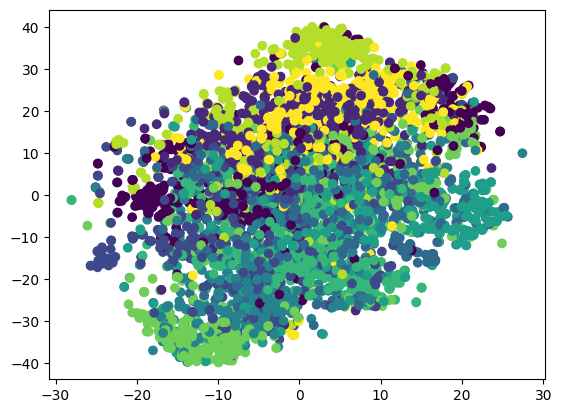

In [15]:
import matplotlib.pyplot as plt

plt.scatter(*X_train_proj.T, c=y_train)

In [16]:
projs_by_perp = {}
for perp in (1, 10, 30, 50, 100):
    projs_by_perp[perp] = TSNE(n_jobs=8, random_state=420, perplexity=perp).fit_transform(features.cpu().numpy())



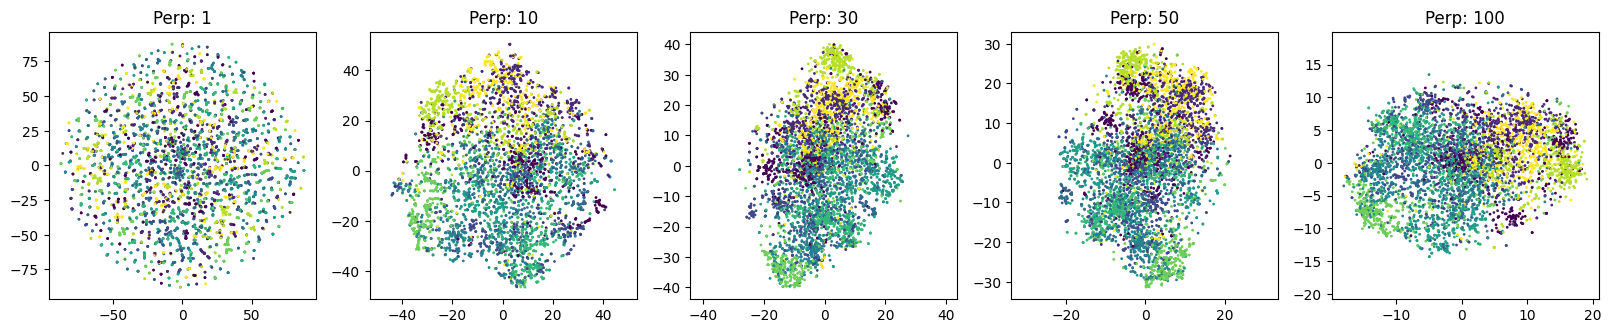

In [24]:

fig, axes = plt.subplots(1, 5, subplot_kw={"aspect": "equal", "box_aspect":1}, figsize=(20, 5))

for (ax, perp) in zip(axes, (1, 10, 30, 50, 100)):
    ax.scatter(*projs_by_perp[perp].T, c=y_train, s=1)
    ax.set_title(f"Perp: {perp}")

In [25]:
projs_by_perp.clear()
for perp in (5, 10, 15, 20, 25):
    projs_by_perp[perp] = TSNE(n_jobs=8, random_state=420, perplexity=perp).fit_transform(features.cpu().numpy())


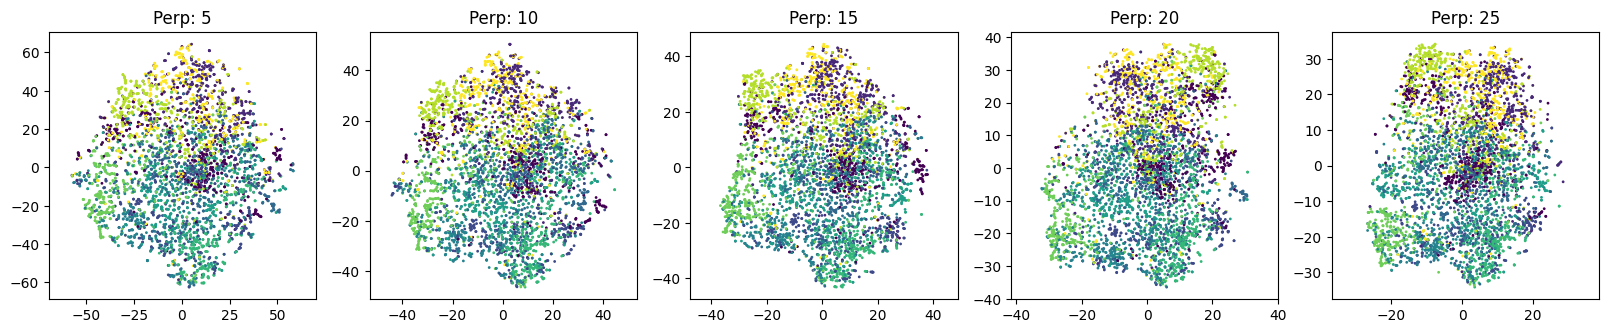

In [27]:
fig, axes = plt.subplots(1, 5, subplot_kw={"aspect": "equal", "box_aspect":1}, figsize=(20, 5))

for (ax, perp) in zip(axes, projs_by_perp):
    ax.scatter(*projs_by_perp[perp].T, c=y_train, s=1)
    ax.set_title(f"Perp: {perp}")

In [28]:
import sys
sys.path.append("../")

from adversarial_dbm_gui.projection import nninv

In [32]:
X_train.shape, features.shape

((5000, 3, 32, 32), torch.Size([5000, 768]))

In [34]:
nninv_model_feats = nninv.NNInv(2, features.shape[1])


In [36]:
nninv_model_feats.fit(TensorDataset(T.tensor(X_train_proj, dtype=T.float32), features), epochs=200)

Epoch 0: Loss = 0.6935
Epoch 50: Loss = 0.6890
Epoch 100: Loss = 0.6890
Epoch 150: Loss = 0.6890


In [37]:
import os
if not os.path.exists("../data/assets/cifar10_features_convnext"):
    os.makedirs("../data/assets/cifar10_features_convnext")

import pathlib
base_path = pathlib.Path("../data/assets/cifar10_features_convnext")
assert base_path.exists()

In [40]:
X_train_feats = features.cpu().numpy()

np.save(base_path / "X_train.npy", X_train_feats)
np.save(base_path / "y_train.npy", y_train)

In [41]:
dl = DataLoader(TensorDataset(X_test_T), batch_size=100, shuffle=False)
test_features = []
for batch in dl:
    data_pts, = batch
    with T.no_grad():
        feats = feature_ex.features(data_pts)
    test_features.append(feats)


TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [42]:
test_features = T.cat(test_features)

In [43]:
X_test_feats = test_features.cpu().numpy()

np.save(base_path / "X_test.npy", X_test_feats)
np.save(base_path / "y_test.npy", y_test)

In [44]:
proj_path = base_path / "tsne"
proj_path.mkdir(exist_ok=False)

In [46]:
np.save(proj_path / "X_proj.npy", projs_by_perp[25])